/home/alol/.local/lib/python3.9/site-packages/highway_env/envs/common/observation.py:215: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_records(
/home/alol/.local/lib/python3.9/site-packages/highway_env/envs/common/observation.py:215: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_records(
/home/alol/.local/lib/python3.9/site-packages/highway_env/envs/common/observation.py:215: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame.from_records(
/home/alol/.local/lib/python3.9/site-packages/highway_env/envs/common/observation.py:215: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

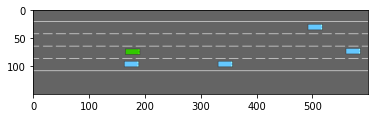

In [4]:
import gym
import highway_env
from matplotlib import pyplot as plt

env = gym.make("racetrack-v0")
env.reset()
for _ in range(3):
    action = [0.1,0.1]
    obs, reward, done, info = env.step(action)
    env.render()

plt.imshow(env.render(mode="rgb_array"))
plt.show()